
### TD(n) - Discrete time
The n-step TD error estimate, TD(n), is
$$\delta_t^{(n)} = \underbrace{R_t + \gamma R_{t+1} + \dots + \gamma^{n-1} R_{t+n-1} + \gamma^n V(s_{t+n})}_{=G^{(n)}_t} - V(s_t) $$

### TD($\theta$) - Conintuous time version of TD(n)

A learning rule that uses the full $\theta$ time window of the LMU memories is
\begin{align} 
    \delta^{(\theta)}(t) &= \int_{0}^{1} \gamma^{1 - \tau} R( t - \theta\tau) d\tau + \gamma V(t) - V(t-\theta) ,\\
    &= \left ( \int_{0}^{1} \gamma^{1 - \tau} \mathbf{P}^{q_r}(\tau) d\tau \right ) \mathbf{m}_{R}(t) + \gamma V(t) - \mathbf{P}^{q_v}(1)\mathbf{m}_{V}(t) ,\\
    \Delta \mathbf{d} &= \kappa  \mathbf{P}^{q_a}(1) \mathbf{m}_{a_j}(t) \delta^{(\theta)}(t).
 \end{align}

#### Discount parameter $\gamma$

After $\theta$ seconds, the future reward is discounted by $\gamma$. So the rate of discounting depends on both $\gamma$ and $\theta$ in the equations above. We would prefer a discount parameter that is in units of seconds and not $\theta$. We can replace $\gamma$ with $\gamma^{\theta}$ in above rule to get reward is discounted by $\gamma$ after 1 second.

\begin{align} 
    \delta^{(\theta)}(t) = \left ( \int_{0}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right ) \mathbf{m}_{R}(t) + \gamma^{\theta} V(t) - \mathbf{P}^{q_v}(1)\mathbf{m}_{V}(t) 
 \end{align}

## Example
Here's a simple example problem. An agent travels around a circle and gets a reward when it is near some particular spot. Our network should learn a value function that anticipates this reward.

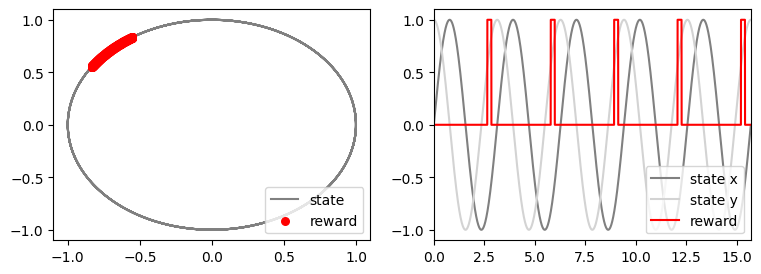

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Very simple RL problem for testing: Go around a circle and get reward at particular spots
# The state is (x,y) position 
T=np.pi*5
dt = 0.001
timesteps = np.arange(0,T,dt)
def sim_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = sim_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards

rewards = reward_fun(timesteps)
    
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

Baseline for comparsion:

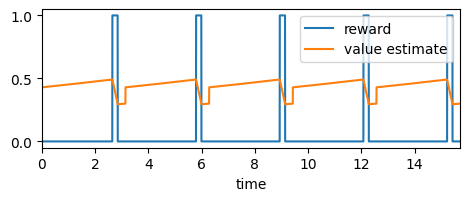

In [2]:
# solution via computing returns
discount  =0.95
returns = [dt*np.sum(discount**(dt*np.arange(len(rewards)-i))*rewards[i:]) for i in range(len(rewards))]

n_period = int(np.pi/dt)
vals_direct=[np.mean([returns[j*n_period + i] for j in range(5)]) for i in range(n_period)]
repeated_vals = np.tile(vals_direct,int(T/np.pi))

plt.figure(figsize=(5.4,1.8))
plt.plot(timesteps,rewards, label='reward')
plt.plot(timesteps[:len(repeated_vals)],repeated_vals, label='value estimate')
plt.xlim([0,T])
plt.xlabel('time')
plt.legend()

In [3]:
import nengo
from rl_networks import ValueCritic

n_neurons_state=400
n_neurons_value=400
discount = 0.95
theta = 0.5

q_a = 8
q_r = 8
q_v = 8


model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TDtheta',T_test=9,learning_rate=1e-4)
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

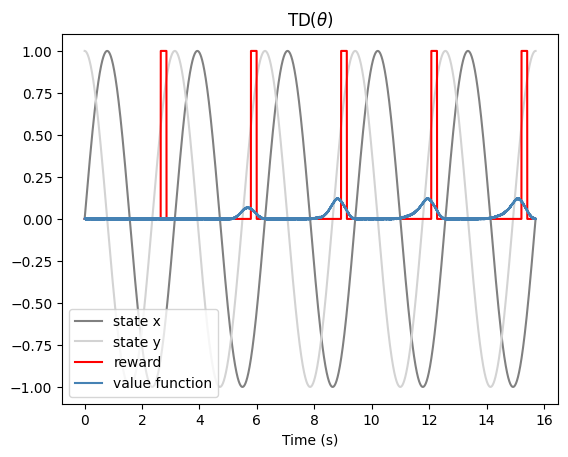

In [4]:
plt.figure()
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')
# note that learning is turned off after 9 seconds

It learns to anticipate the reward. Let's try a larger $\theta$:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

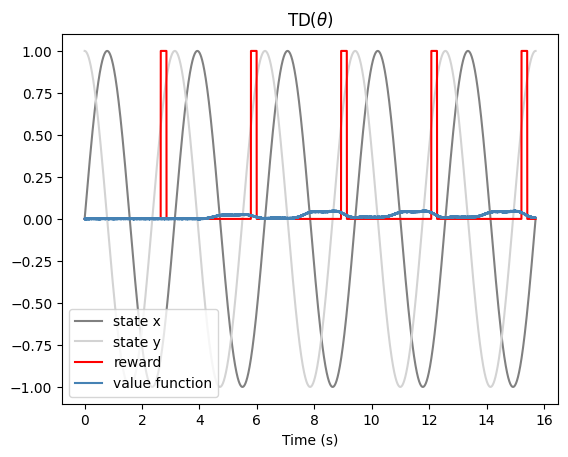

In [5]:
theta = 1.5

model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TDtheta',T_test=9,learning_rate=1e-4)
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

plt.figure()
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

Zooming in:

Text(0.5, 0, 'Time (s)')

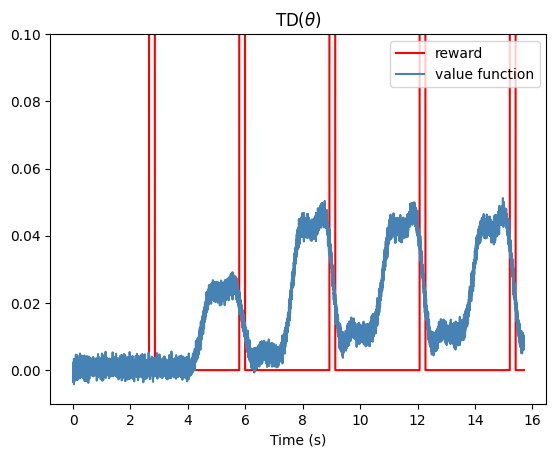

In [6]:

plt.figure()
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.ylim([-0.01,0.1])
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

Running longer:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

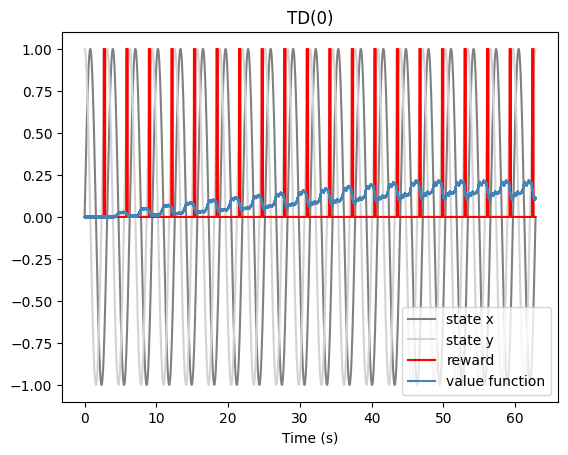

In [9]:
model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TDtheta',T_test=np.pi*15,learning_rate=1e-4)
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(np.pi*20)
ts = sim.trange() 


plt.figure()
plt.plot(ts,sim_fun(ts)[:,0], label='state x',color='grey')
plt.plot(ts,sim_fun(ts)[:,1], label='state y',color='lightgrey')
plt.plot(ts,reward_fun(ts), label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\theta$)')
plt.xlabel('Time (s)')